# TensorFlow on Textual Data

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
import math
import os
import random
import sqlite3

---
## Import Data

In [2]:
conn = sqlite3.connect('/Users/desiredewaele/Google Drive/Datasets/tidyData.sqlite')
speeches = pd.read_sql("select date, president, text from Speeches where speech is 'Weekly Address'", conn)
speeches = speeches[speeches.president.str.contains('Barack Obama|William J. Clinton|George W. Bush', regex=True)]
speeches = speeches.sort_values('date', ascending=True)
speeches.tail()

,date,president,text
1575,2016-12-17,Barack Obama,hi everybody if you ve ever played a game of b...
1573,2016-12-24,Barack Obama,the president merry christmas everybody one of...
1576,2016-12-31,Barack Obama,happy new year everybody at a time when we tur...
1579,2017-01-07,Barack Obama,since the days of george washington presidents...
1581,2017-01-14,Barack Obama,this week i traveled to chicago to deliver my ...


In [3]:
words = sum(list(speeches.text.apply(lambda x: x.split())), [])

In [4]:
print('Total number of words:', len(words))
print('Number of unique words:', len(set(words)))

('Total number of words:', 885989)
('Number of unique words:', 15587)


---
## Data Pre-Proccessing

In [5]:
def buildDataset(words, VOCAB):
    # Count is a list of tuples with frequent words and # occurences
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(VOCAB - 1))
    # Dictionary is a dictionary with all frequent words and count index
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # Data is a list containing count index for all words
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    rDictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, rDictionary

In [6]:
VOCAB = 3000
data, count, dictionary, rDictionary = buildDataset(words, VOCAB)

In [7]:
print('Five most common words:', count[:5])
print('Five first words in speeches:', words[:8])
print('Five first words count index:', data[:8])
#del words

('Five most common words:', [['UNK', 52101], (u'the', 43154), (u'to', 33493), (u'and', 32846), (u'of', 22913)])
('Five first words in speeches:', [u'good', u'morning', u'this', u'is', u'bill', u'clinton', u'and', u'this'])
('Five first words count index:', [61, 124, 13, 14, 103, 2631, 3, 13])


---
## Generate Training Batches
This function generates two arrays. Batch contains a word 

In [8]:
data_index = 0

def generateBatch(BATCH, SKIPS, WINDOW):
    global data_index
    assert BATCH % SKIPS == 0
    assert SKIPS <= 2 * WINDOW
    batch = np.ndarray(shape=(BATCH), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH, 1), dtype=np.int32)
    span = 2 * WINDOW + 1 # Consider WINDOW words left & right
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(BATCH // SKIPS):
        target = WINDOW  # target label at the center of the buffer
        targets_to_avoid = [ WINDOW ]
        for j in range(SKIPS):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * SKIPS + j] = buffer[WINDOW]
            labels[i * SKIPS + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [9]:
print('data:', [rDictionary[di] for di in data[:8]])

for SKIPS, WINDOW in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generateBatch(16, SKIPS, WINDOW)
    print('\nwith num_skips = %d and skip_window = %d:' % (SKIPS, WINDOW))
    print('    batch:', [rDictionary[bi] for bi in batch])
    print('    labels:', [rDictionary[li] for li in labels.reshape(16)])

('data:', [u'good', u'morning', u'this', u'is', u'bill', u'clinton', u'and', u'this'])

with num_skips = 2 and skip_window = 1:
('    batch:', [u'morning', u'morning', u'this', u'this', u'is', u'is', u'bill', u'bill', u'clinton', u'clinton', u'and', u'and', u'this', u'this', u'morning', u'morning'])
('    labels:', [u'this', u'good', u'is', u'morning', u'this', u'bill', u'is', u'clinton', u'bill', u'and', u'this', u'clinton', u'and', u'morning', u'on', u'this'])

with num_skips = 4 and skip_window = 2:
('    batch:', [u'this', u'this', u'this', u'this', u'is', u'is', u'is', u'is', u'bill', u'bill', u'bill', u'bill', u'clinton', u'clinton', u'clinton', u'clinton'])
('    labels:', [u'good', u'bill', u'morning', u'is', u'bill', u'this', u'clinton', u'morning', u'and', u'is', u'this', u'clinton', u'is', u'this', u'bill', u'and'])


---
## Train Embeddings with Skip-Gram Model

In [10]:
BATCH = 128
EMBED = 8 # Dimension of the embedding vector.
WINDOW = 1 # How many words to consider left and right.
SKIPS = 2 # How many times to reuse an input to generate a label.
STEPS = 100001

# We pick a random validation set to sample nearest neighbors. Here we limit the validation samples 
# to the words that have a low numeric ID, which by construction are also the most frequent. 
valid_size = 5 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    tfTrainX = tf.placeholder(tf.int32, shape=[BATCH])
    tfTrainY = tf.placeholder(tf.int32, shape=[BATCH, 1])
    tfValidX = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    # Embedding matrix, reducing vocab size to embed size
    embeddings = tf.Variable(tf.random_uniform([VOCAB, EMBED], -1.0, 1.0)) 
    weights = tf.Variable(tf.truncated_normal([VOCAB, EMBED], stddev=1.0 / math.sqrt(EMBED)))
    biases = tf.Variable(tf.zeros([VOCAB]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, tfTrainX)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=weights, biases=biases, inputs=embed, 
        labels=tfTrainY, num_sampled=num_sampled, num_classes=VOCAB))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, tfValidX)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    average_loss = 0
    for step in range(STEPS):
        batchX, batchY = generateBatch(BATCH, SKIPS, WINDOW)
        _, l = session.run([optimizer, loss], {tfTrainX: batchX, tfTrainY: batchY})
        average_loss += l
        if step % 50000 == 0:
            if step > 0:
                average_loss = average_loss / 50000
            # The average loss is an estimate of the loss over the last 50000 batches.
            print('\nAverage loss at step %d: %f' % (step, average_loss))
            average_loss = 0
            
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = rDictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = rDictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()


Average loss at step 0: 6.222207
Nearest to has: establish, lady, yesterday, convention, begun, commerce, campaign, small,
Nearest to children: airmen, these, we, standards, draw, because, understands, tremendous,
Nearest to health: industry, single, harmful, lasting, friday, policies, pretty, continent,
Nearest to about: being, meets, name, teenagers, level, held, decide, neither,
Nearest to jobs: easier, civilian, conflicts, himself, difficult, volunteer, fallen, traveled,

Average loss at step 50000: 3.494199
Nearest to has: gained, was, elect, ended, wrote, reached, launched, declared,
Nearest to children: kids, borders, entrepreneurs, families, exports, troops, minds, neighbors,
Nearest to health: opening, student, preventive, rent, cutting, managed, taxes, immediate,
Nearest to about: at, within, below, with, behind, for, reminds, beyond,
Nearest to jobs: million, unfinished, advice, unemployed, dreams, life, futures, citizenship,

Average loss at step 100000: 3.427000
Nearest t

---
## Visualize Embeddings

In [12]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    plt.savefig(filename)
    plt.show()

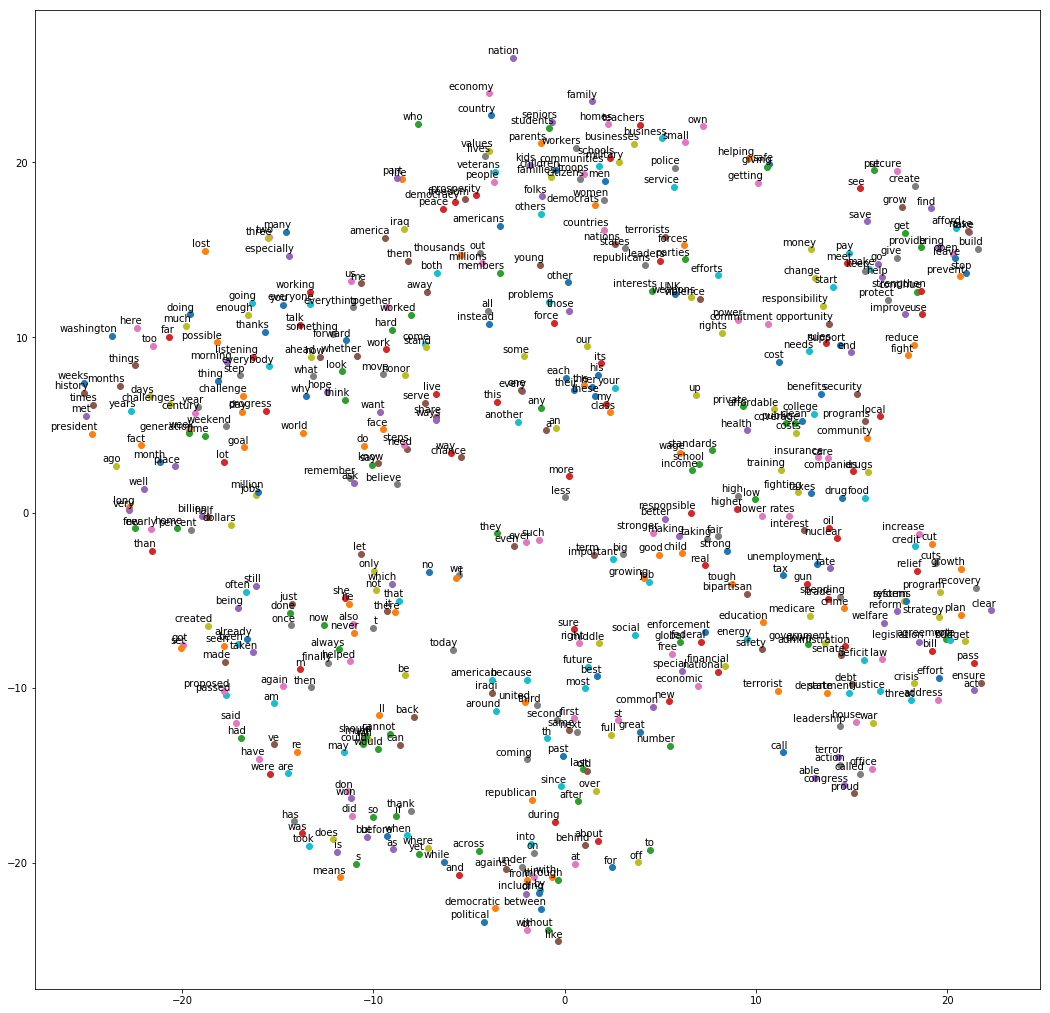

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(final_embeddings[:500, :]) # Plot only 500
labels = [rDictionary[i] for i in xrange(500)]
plot_with_labels(low_dim_embs, labels)

---
## Text classification

In [14]:
final_embeddings.shape

(3000, 8)

In [15]:
longest = max(speeches.text.apply(lambda x: len(x)))
def pad(speech):
    speech = np.asarray(speech.split())
    pad = np.chararray((longest - len(speech),))
    pad[:] = '|'
    return np.append(speech, pad)

words = speeches.text.apply(pad).values

In [16]:
words.size

1227

In [17]:
words.reshape((-1, longest))

ValueError: cannot reshape array of size 1227 into shape (13946)

In [18]:
words.shape

(1227,)

In [30]:
embeddings = np.apply_along_axis(sentenceToTensors, 0, words)

NameError: name 'sentenceToTensors' is not defined

In [ ]:
def sentenceToTensors(speech):
    embedList = np.empty(len(speech))
    for i, w in enumerate(speech):
        if w in dictionary:
            index = dictionary[w]
        else:
            index = 0
        np.append(embedList, final_embeddings[index])
    return embedList

In [ ]:
sentenceToTensors(words[0])

In [ ]:
longest

In [ ]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

    # Model.
    def model(x):
        # Convolutional layer 1
        x = tf.nn.conv2d(x, w1, [1, 1, 1, 1], padding='SAME') + b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Convolutional layer 2
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME') + b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Fully connected layer
        x = tf.reshape(x, (-1, SIZE // 4 * SIZE // 4 * 2*DEPTH))
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.RMSPropOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, axis=1),"probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100